## Code for Guinier fitting and plotting
This notebook performs an iterative Guinier analysis on SAXS data and writes out the parameters for use in downstream dimensionless Kratky analysis. This notebook takes three input files of simulated (1 file) and experimental (2 files, high & low concentrations) scattering data. These must be formatted as three-column .dat files, in which the columns are: q, I(q), and error. The input file 'sim_fitted_out.dat' is the FoxS-calculated scattering profile after re-scaling against the low-concentration experimental dataset.

In [46]:
## import packages ##

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.ticker as ticker
import scipy.stats
import bioxtasraw.RAWAPI as raw

In [3]:
## import scattering profiles via raw ##

sim = raw.load_profiles('sim_fitted_out.dat')[0]
high = raw.load_profiles('SERF_1.1mM.dat')[0]
low = raw.load_profiles('SERF_0.56mM.dat')[0]

In [18]:
## define function that performs a few calculations followed by guinier analysis

### parameters ###
# dataset == desired dataset for fitting
# q0_max == starting maximum q value for fitting, set to 0.06 here (float)
# q0_min == starting minimum q value for fitting, set to 0.01 here (float)
# threshold == maximum allowed value for q*Rg, set to 1.1 for IDPs

### returns fit_params, sax_params ###
# fit_params = [slope, intercept, r, p, stderr]
# saxs_params = [Rg, Rg_err, I0, qmax, qRg]

def auto_guinier(dataset, q0_max, q0_min, threshold):
    q = dataset.getQ()
    I = dataset.getI()
    err = dataset.getErr()
    
    lnI = np.log(I)
    q2 = q * q
    
    # define empty lists for relevant q^2 and lnI values
    guin_q2 = []
    guin_lnI = []
    
    for x in range(0, len(q2)):
        if (q[x] > q0_min and q[x] < q0_max):
            guin_q2.append(q2[x])
            guin_lnI.append(lnI[x])
    
    # perform first fit using entire q2 range
    slope0, intercept0, r0, p0, stderr0 = scipy.stats.linregress(guin_q2, guin_lnI)
    
    # calculate Rg and qRg for initial fit
    Rg0 = np.sqrt(-3 * slope0)
    qRg0 = Rg0 * max(np.sqrt(guin_q2))
    
    # truncate q^2 range by one (highest) value at each iteration & refit Guinier until qRg < threshold 
    qRg = qRg0
    j = 1
    while qRg > threshold:
        q2_new = guin_q2[:-j]
        lnI_new = guin_lnI[:-j]
        
        slope, intercept, r, p, stderr = scipy.stats.linregress(q2_new, lnI_new)
        
        Rg = np.sqrt(-3 * slope)
        qmax = max(np.sqrt(q2_new))
        qRg = Rg * qmax
        I0 = np.exp(intercept)
        
        j = j + 1
    
    # error propagation for fitted Rg
    err_plus = slope + stderr
    err_minus = slope - stderr
    
    Rg_err_plus = np.sqrt(-3 * err_plus)
    Rg_err_minus = np.sqrt(-3 * err_minus)
    
    Rg_err = (abs(Rg_err_plus - Rg) + abs(Rg_err_minus - Rg)) / 2
    
    fit_params = [slope, intercept, r, p, stderr]
    saxs_params = [Rg, Rg_err, I0, qmax, qRg]
    
    print('Rg = ' +str(Rg))
    print('Rg err = ' +str(Rg_err))
    print('I(0) = ' +str(I0))
    print('qmax = ' +str(qmax))
    print('qRg = ' +str(qRg))
   
    print('q range defined after ' +str(j)+ ' iterations.')
    
    return fit_params, saxs_params, q2_new, lnI_new
    

In [42]:
## perform iterative fitting for each dataset ##

sim_fit, sim_params, sim_q2_new, sim_lnI_new = auto_guinier(sim, 0.06, 0.015, 1.1)
high_fit, high_params, high_q2_new, high_lnI_new = auto_guinier(high, 0.06, 0.015, 1.1)
low_fit, low_params, low_q2_new, low_lnI_new = auto_guinier(low, 0.06, 0.015, 1.1)

# UNCOMMENT to write out SAXS parameters for each dataset; to be used in 'saxs_plotter' script
#np.savetxt('sim_guinier_params.txt', sim_params)
#np.savetxt('high_guinier_params.txt', high_params)
#np.savetxt('low_guinier_params.txt', low_params)

Rg = 24.824708834113647
Rg err = 0.046924664294667906
I(0) = 4.593140027413823
qmax = 0.044
qRg = 1.0922871887010004
q range defined after 16 iterations.
Rg = 24.503295398516087
Rg err = 0.1325292677738652
I(0) = 10.372903835093473
qmax = 0.0447913
qRg = 1.0975344551835535
q range defined after 19 iterations.
Rg = 24.474041953444345
Rg err = 0.2211609486051973
I(0) = 4.55633374511331
qmax = 0.0447913
qRg = 1.0962241553493117
q range defined after 19 iterations.


In [43]:
## function that uses the saxs params from the previous cells to generate a line of best fit (Guinier fit) and residuals for plotting ##

### parameters ###
# params == desired dataset for fitting, i.e., 'high_fit' (string)
# q2 == list of "q2_new" values for desired dataset
# lnI == list of "lnI_new" values for desired dataset

### returns ###
# data_out = [q2, lnI, fit, residuals]

def gen_guinier_fit(params, q2, lnI):
    
    fit = params[1] + params[0] * np.array(q2)

    residuals = fit - lnI
    
    data_out = [q2, lnI, fit, residuals]
    
    return data_out

In [44]:
## perform fit and residual calculations with above function ##

high_guin_data = gen_guinier_fit(high_fit, high_q2_new, high_lnI_new)
low_guin_data = gen_guinier_fit(low_fit, low_q2_new, low_lnI_new)

# UNCOMMENT to write out the q^2, lnI, fit, and residual values
# np.savetxt('high_guinier_data_fit.txt', high_guin_data)
# np.savetxt('low_guinier_data_fit.txt', low_guin_data)

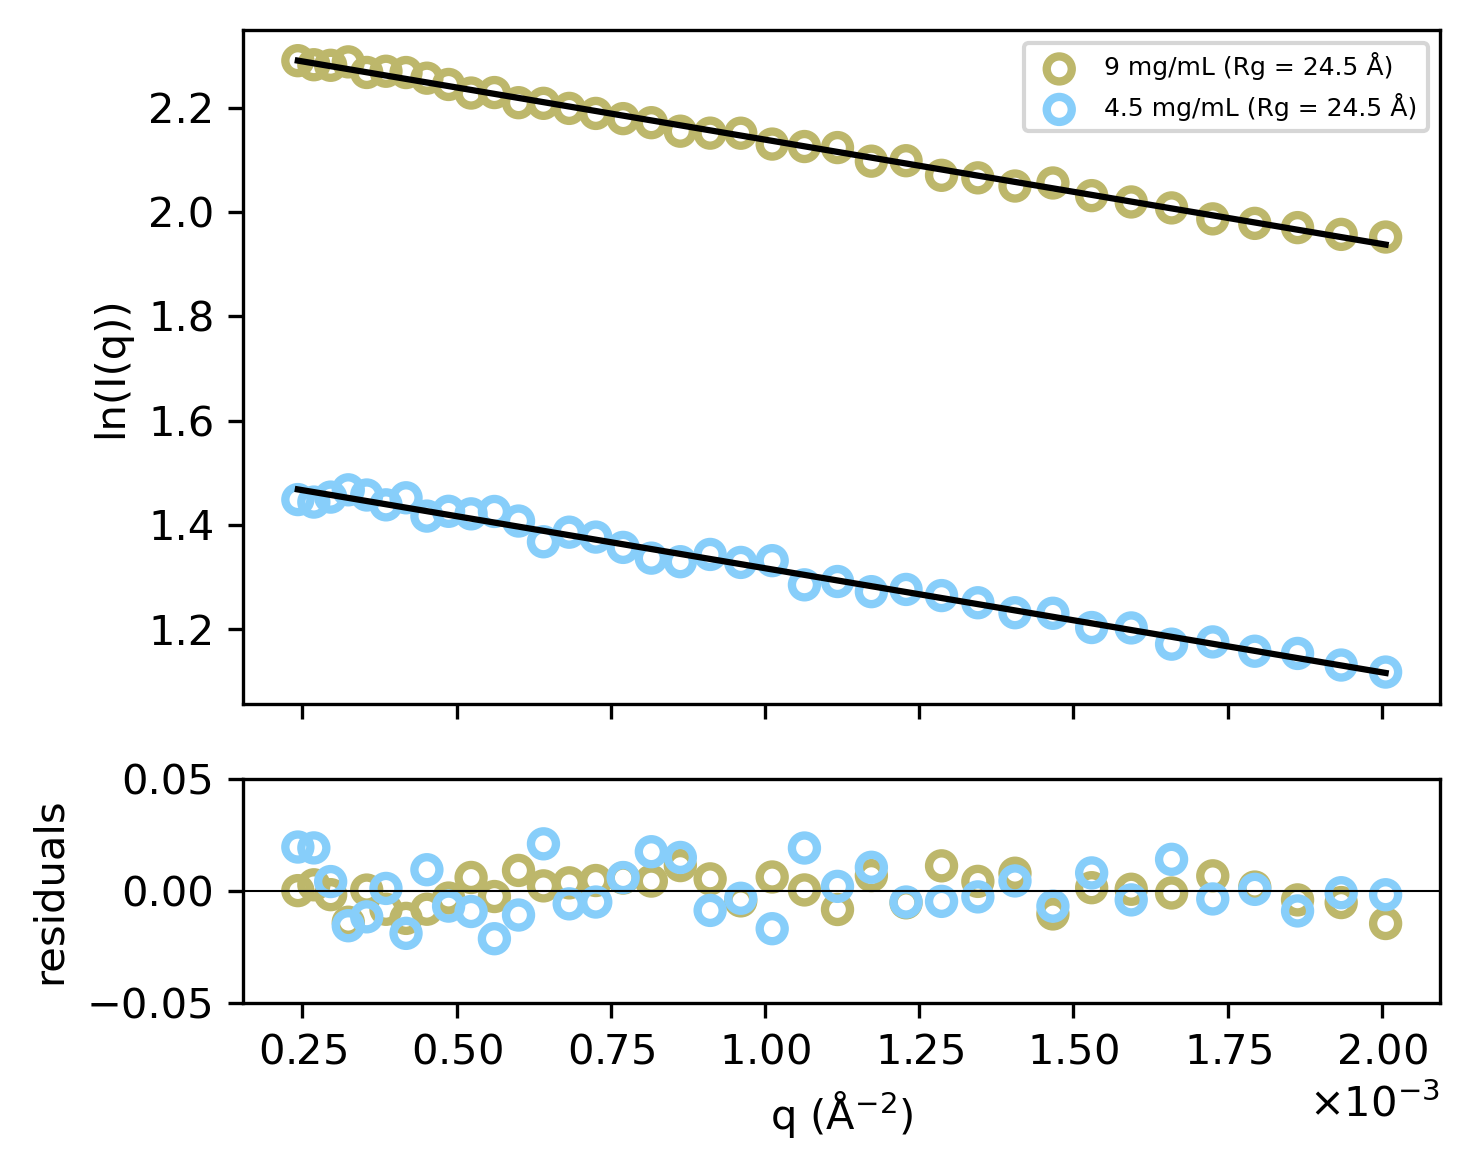

In [50]:
## plot data & Guinier fits -- generates Figure S2B ##

# create subplot
f, (a0, a1) = plt.subplots(2, 1, figsize = (5,4), sharex = True, dpi = 300, gridspec_kw={'height_ratios': [3, 1]})

high_color = 'darkkhaki'
low_color = 'lightskyblue'

# plot data, fit, and residuals
a0.scatter(high_guin_data[0], high_guin_data[1], color = None, edgecolors = high_color, facecolor = 'None', lw = 2, label = '9 mg/mL (Rg = ' +str(round(high_params[0], 1))+ ' Å)')
a0.plot(high_guin_data[0], high_guin_data[2], color = 'k')

a0.scatter(low_guin_data[0], low_guin_data[1], color = None, edgecolors = low_color, facecolor = 'None', lw = 2, label = '4.5 mg/mL (Rg = ' +str(round(low_params[0], 1))+ ' Å)')
a0.plot(low_guin_data[0], low_guin_data[2], color = 'k')


# residuals subplot
a1.axhline(y = 0, color = 'k', lw = 0.5)
a1.scatter(high_guin_data[0], high_guin_data[3], edgecolors = high_color, facecolor = 'None', lw = 2)
a1.scatter(low_guin_data[0], low_guin_data[3], edgecolors = low_color, facecolor = 'None', lw = 2)

plt.xlabel(r'q $(\mathrm{\AA}^{-2})$')
a0.set_ylabel('ln(I(q))')
a1.set_ylabel('residuals')

a1.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
a1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

a1.set_ylim(-0.05, 0.05)

a0.legend(loc = 'best',prop={'size': 6})
f.tight_layout()

# UNCOMMENT to save figure as PDF
# f.savefig('Figure_S2B_guinier.pdf', format = 'pdf', dpi = 300)

plt.show()